# Regression of Pentane-Hexane and Pentane-Octane

In [1]:
"""
Created on Wed May 22 12:01 2019

@author: Soeren Brandt
"""

# import our modules
import fra_expt

#import some generally useful modules
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
segmentcolors = [(.8, 0, 0), (0, .8, 0), (0, 0, .8)]
color = {"train": [0.5, 0.5, 0.5], "test": [0, 0, 0]}

##### Plot functions

In [3]:
def calculate_R2(actual,predicted):
    # convert to array
    actual = np.array(actual).reshape(1,-1)
    predicted = np.array(predicted).reshape(1,-1)
    
    # calculate errors
    res_ss = np.sum((predicted-actual)**2)
    total_ss = np.sum((np.mean(actual)-actual)**2)
    
    return 1-res_ss/total_ss


def plot_regression(actual, predicted, c='k'):
    # plots the real vs predicted concentrations
    plt.figure(figsize = (3,5))
    plt.xlabel('Actual Pentane Concentration\n(Mole Fraction)', fontsize = 12)
    plt.ylabel('Predicted Pentane Concentration (Mole Fraction)', fontsize = 12)
    ax = plt.gca()
    ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = 11)
    
    # plot line representing 1:1 correspondence
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'--',c='k',linewidth=1)
    
    # scatter predictions
    plt.scatter(np.array(actual),np.array(predicted),c=c,s=15)

##### Bagging classifier

In [4]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

def train_ridge(train_set, train_lbl, regions, alpha = None):
    # prepare dictionary for regressions
    regress_in = {}
    
    for region in set(regions): # changed this without checking on 5/8
        # separate training set
        X = [train_set[n] for n,reg in enumerate(regions) if reg == region]
        Y = [train_lbl[n] for n,reg in enumerate(regions) if reg == region]
        
        # perform linear regression in region
        if alpha == None:
            regress_in[region] = GridSearchCV(Ridge(), cv=min(len(X),5), param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]}) # OR svm.SVR(C=1e1,gamma=0.7e1, kernel='rbf')#
        else:
            regress_in[region] = svm.SVR(C=1e1,gamma=0.7e1, kernel='rbf')#Ridge(alpha=alpha, fit_intercept=False)
        regress_in[region].fit(X, Y)
    
    return regress_in


def model_prediction(classifier, regression, test_set):
    # prepare output of predictions
    prediction = []

    for deriv in test_set:
        # reshape test data to conform with predictors
        deriv = np.array(deriv).reshape(1,-1)

        # determines the concentration level based on the random forest classifier
        region = classifier.predict(deriv)[0] # high = break_clf.predict(deriv)
        
        # predict concentration
        prediction.append(regression[region].predict(deriv))

    return prediction

## Pentane-Hexane (ideal mixture)

#### Experimental data

In [5]:
from datasets import *
#exp_set = binary_mixtures(['Pentane', 'Hexane'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([15.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([1.3]))
exp_set = binary_mixtures(['Pentane', 'Hexane'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([4.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([0.4]))
#train_set, test_set = train_test_split(exp_set)

In [6]:
exp_set[1.0].remove(622)

Load data

In [7]:
from data_functions import load_set_from_CSV
exp_derivs, exp_concentrations, m = load_set_from_CSV(exp_set)

Loading experimental data 
0.0: [===================0] 100%   1/11 complete
0.1: [===================0] 100%   2/11 complete
0.2: [===================0] 100%   3/11 complete
0.3: [===================0] 100%   4/11 complete
0.4: [===================0] 100%   5/11 complete
0.5: [===================0] 100%   6/11 complete
0.6: [===================0] 100%   7/11 complete
0.7: [===================0] 100%   8/11 complete
0.8: [===================0] 100%   9/11 complete
0.9: [===================0] 100%   10/11 complete
1.0: [===================0] 100%   11/11 complete
Length of experimental set loaded: 31


Sort dataset

In [8]:
#from datasets import sort_by_set
#train_derivs, train_lbl, test_derivs, test_lbl = sort_by_set(exp_derivs, train_set, test_set)

Normalize dataset

In [9]:
for num in exp_derivs.keys():
    exp_derivs[num] = exp_derivs[num]/np.sqrt(np.sum(exp_derivs[num]**2))

#### Plot phase derivatives

In [10]:
pentane_blue = (69./255, 127./255, 181./255)
hexane_orange = (238./255, 124./255, 48./255)

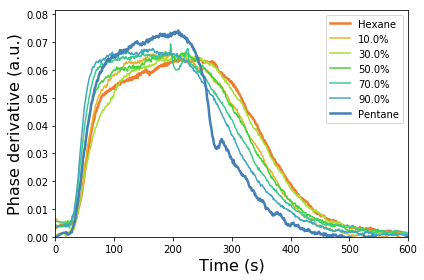

In [11]:
from plot_functions import get_colors, plot_deriv, get_gradient_colors, get_markers
import colorsys

# create full dictionary
all_derivs = exp_derivs
num_lbl = exp_concentrations
all_lbls = sorted(list(set(num_lbl.values())))

# averages
fig, ax = plt.subplots()

maximum = 0
colorset = get_colors(4)
#face_color = np.flip(get_gradient_colors(len(all_lbls), colorset[0], colorset[-1]), axis = 0) # unique face color for each chemical in data set
face_color = np.flip(get_gradient_colors(len(all_lbls), pentane_blue, hexane_orange), axis = 0)
markers = get_markers(len(all_lbls))
for n, lbl in enumerate(all_lbls):
    if lbl not in [0.2, 0.4, 0.6, 0.8] + [0.25, 0.33, 0.67, 0.75]:
        # get phase derivatives
        nums = [key for key in num_lbl.keys() if num_lbl[key] == lbl]
        phase_derivs = [all_derivs[num]/np.sqrt(np.sum(all_derivs[num]**2)) for num in nums]

        # calculate average
        avg = np.average(phase_derivs, axis = 0)

        maximum = np.max([maximum, np.max(avg)])
        #plot_deriv(avg, labels = lbl, norm = True, ax = ax, color = face_color[n], marker='s',markevery=50);
        
        #phase_deriv = phase_deriv/np.sqrt(np.sum(phase_deriv**2))
        if lbl == int(lbl):
            if lbl == 0:
                ax.plot(avg, label = "Hexane", color = face_color[n], linewidth=2.5)
            else:
                ax.plot(avg, label = "Pentane", color = face_color[n], linewidth=2.5)
        else:
            ax.plot(avg, label = str(lbl*100) + "%", color = face_color[n])#, marker=markers[n], markevery=int(0.03*len(avg)))
        
# Clean up plot
plt.xlim((0,600))
plt.ylim((0, 1.1*maximum))

# Define image labels
plt.ylabel('Phase derivative (a.u.)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x',colors='black')
ax.tick_params(axis='y',colors='black')

# Image aspect ratio
#xext, yext = plt.gca().axes.get_xlim(), plt.gca().axes.get_ylim()
#xrange = xext[1] - xext[0]
#yrange = yext[1] - yext[0]
#plt.gca().set_aspect(1 * abs(xrange / yrange)) # This is the line that causes the warnings about unicode

plt.legend()
plt.tight_layout()
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C6 phase derivs.png', dpi=300)

#### Support Vector Regression

In [12]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# split dataset into training and testing
train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs.values(), exp_concentrations.values(), test_size=1/2.5, random_state=0)

#------------------------------------------------------------#
# SVC
#------------------------------------------------------------#
SVR = svm.SVR(C=1e1,gamma=0.7e1, kernel='rbf')
SVR.fit(train_derivs, train_lbl)
predicted = SVR.predict(test_derivs)
print("Training accuracy: " + str(SVR.score(train_derivs, train_lbl)) + " (" + str(len(train_lbl)) + ")")
print("Validation accuracy: " + str(SVR.score(test_derivs, test_lbl)) + " (" + str(len(test_lbl)) + ")")

Training accuracy: 0.9330640597715504 (18)
Validation accuracy: 0.94355068905952 (13)


Plotting

(-0.05, 1.05)

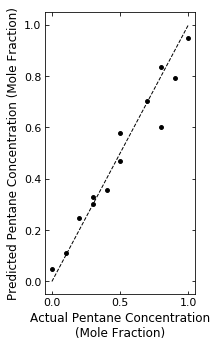

In [96]:
plot_regression(test_lbl, predicted, c=color["test"])
plt.tight_layout()
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C6 SVR.png', dpi=300)

##### with segmented regression
requires PCA: segmented regression is performed on PC1

In [97]:
from piecewise.regressor import piecewise
from sklearn.decomposition import PCA

# split dataset into training and testing
train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs.values(), exp_concentrations.values(), test_size=1/2.5, random_state=0)

# perform PCA
pca = PCA()
train_pca = pca.fit_transform(train_derivs)
test_pca = pca.transform(test_derivs)

# run segmented regression algorithm
error_thresh = 0.07
model = piecewise(train_lbl,train_pca[:,0],error_thresh)

plot segmentation results

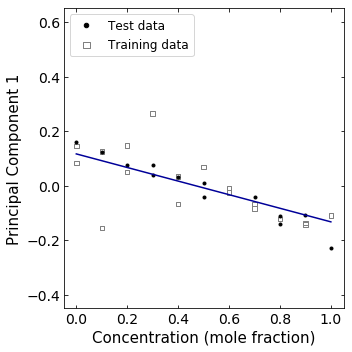

In [98]:
# plot segmented regression results
plt.figure(figsize = (5,5))
plt.plot(np.array(test_lbl),np.array(test_pca[:, 0]), '.', c=color["test"], label = "Test data")
plt.scatter(train_lbl, train_pca[:, 0],c='None', marker='s',s=20,edgecolors=color["train"],linewidths=1, label = "Training data")
for seg in model.segments:
    concs_new = [seg.start_t, seg.inclusive_end_t]
    y_hat = [seg.predict(conc) for conc in concs_new]
    plt.plot(concs_new, y_hat, c=(0, 0, .8*0.75))
    
plt.xlabel('Concentration (mole fraction)', fontsize = 15)
plt.ylabel('Principal Component 1', fontsize = 15)

ax = plt.gca()
ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = 14)

plt.legend(loc='upper left', fontsize = 12, markerscale = 1.5)
plt.tight_layout()
#plt.savefig('segmented_regression_explanation0.svg', bbox_layout='tight')
plt.tight_layout()
plt.xlim([-0.05, 1.05])
plt.ylim([-0.45, 0.65])
plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C6 segmReg.png', dpi=300)

perform bagging classification

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
import warnings

# split dataset into training and testing
train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs.values(), exp_concentrations.values(), test_size=1/2.5, random_state=0)

#------------------------------------------------------------#
# Bagging classifier with piecewise boundaries
#------------------------------------------------------------#
# get boundaries from piecewise model
for seg in model.segments:
    concs_new = [seg.start_t, seg.inclusive_end_t]
    y_hat = [seg.predict(conc) for conc in concs_new]

#defines boundaries of regression
break_y_da = []
for y in train_lbl:
    #for n, seg in enumerate(model.segments):
    findSegment = [y <= seg.inclusive_end_t for seg in model.segments]
    break_y_da.append(findSegment.index(True))

#creates classifier for the categories for low-medium and high concentration ranges.
break_clf = BaggingClassifier(n_estimators = 50, max_samples = 1.0, max_features = 10)
break_clf.fit(train_derivs, break_y_da)

#------------------------------------------------------------#
# Train regression and predict results
#------------------------------------------------------------#
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Train ridge regression for each region in break_y_da
    regressions = train_ridge(train_derivs, train_lbl, break_y_da, alpha = 0.003)

    # predict testing set concentrations
    predicted = model_prediction(break_clf, regressions, test_derivs)

    # calculate performance on training data as well
    matched = model_prediction(break_clf, regressions, train_derivs)

    print("Training accuracy: " + str(calculate_R2(train_lbl, matched)) + " (" + str(len(train_lbl)) + ")")
    print("Validation accuracy: " + str(calculate_R2(test_lbl, predicted)) + " (" + str(len(test_lbl)) + ")")

Training accuracy: 0.9330640597715504 (18)
Validation accuracy: 0.94355068905952 (13)


Plotting

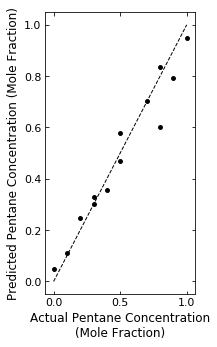

In [53]:
plot_regression(test_lbl, predicted)
plt.tight_layout()
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C8 segRegSVR.png', dpi=300)

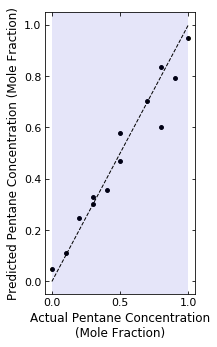

In [54]:
plt.figure(figsize = (3,5))
plt.xlabel('Actual Pentane Concentration\n(Mole Fraction)', fontsize = 12)
plt.ylabel('Predicted Pentane Concentration (Mole Fraction)', fontsize = 12)
ax = plt.gca()
ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = 11)
actual = test_lbl

# plot line representing 1:1 correspondence
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'--',c='k',linewidth=1)

# scatter non-segmented predictions
#plt.scatter(np.array(actual),np.array(predicted1),c=(0.5,0.5,0.5),s=15)
#plt.scatter(np.array(actual),np.array(predicted1),c='None', marker='o',s=20,edgecolors='r',linewidths=1)

# scatter predictions
plt.scatter(np.array(actual),np.array(predicted),c=color["test"],s=15)

# add model regions
colors = segmentcolors #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
for n, segment in enumerate(model.segments):
    plt.axvspan(segment.start_t, segment.inclusive_end_t, facecolor=colors[np.mod(2,len(colors))], alpha=0.1)

# clean up plot and save
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.tight_layout()
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C6 segRegSVR+col.png', dpi=300)

## Pentane-Octane (non-ideal mixture)

#### Experimental data

In [55]:
from datasets import *
exp_set = binary_mixtures(['Pentane', 'Octane'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([15.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([1.3]))
#train_set, test_set = train_test_split(exp_set)

Adjust dataset

In [56]:
coop_set = range(241,246)+ range (247,248) + [208,209,283,174,203] + [216,217,273,218,219,220,230,272,274,279,233,236,434,435] + range(386,401)
for key, values in exp_set.items():
    for value in [num for num in values if num not in coop_set]:
        exp_set[key].remove(value)
        
# remove empty sets
    for key, values in exp_set.items():
        if not values:
            exp_set.pop(key)
#train_set, test_set = train_test_split(exp_set)

Load data

In [57]:
from data_functions import load_set_from_CSV
exp_derivs, exp_concentrations, m = load_set_from_CSV(exp_set)

Loading experimental data 
0.0: [===================0] 100%   1/14 complete
0.1: [===================0] 100%   2/14 complete
0.2: [===================0] 100%   3/14 complete
0.25: [===================0] 100%   4/14 complete
0.3: [===================0] 100%   5/14 complete
0.33: [===================0] 100%   6/14 complete
0.5: [===================0] 100%   7/14 complete
0.6: [===================0] 100%   8/14 complete
0.67: [===================0] 100%   9/14 complete
0.7: [===================0] 100%   10/14 complete
0.75: [===================0] 100%   11/14 complete
0.8: [===================0] 100%   12/14 complete
0.9: [===================0] 100%   13/14 complete
1.0: [===================0] 100%   14/14 complete
Length of experimental set loaded: 37


Sort dataset (moved to later, to avoid getting small test set)

In [58]:
#from datasets import sort_by_set
#train_derivs, train_lbl, test_derivs, test_lbl = sort_by_set(exp_derivs, train_set, test_set)

Normalize dataset

In [59]:
for num in exp_derivs.keys():
    exp_derivs[num] = exp_derivs[num]/np.sqrt(np.sum(exp_derivs[num]**2))

#### Plot phase derivatives

In [60]:
pentane_blue = (69./255, 127./255, 181./255)
octane_red = (192./255, 46./255, 38./255)

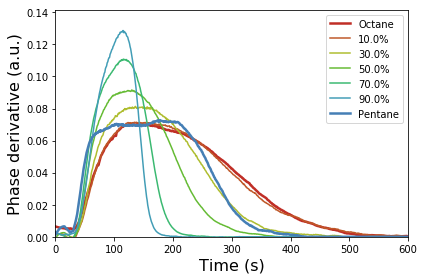

In [61]:
from plot_functions import get_colors, plot_deriv, get_gradient_colors, get_markers

# create full dictionary
all_derivs = exp_derivs
num_lbl = exp_concentrations
all_lbls = sorted(list(set(num_lbl.values())))

# averages
fig, ax = plt.subplots()

maximum = 0
colorset = get_colors(4)
#face_color = np.flip(get_gradient_colors(len(all_lbls), colorset[0], colorset[-1]), axis = 0) # unique face color for each chemical in data set
face_color = np.flip(get_gradient_colors(len(all_lbls), pentane_blue, octane_red), axis = 0)
markers = get_markers(len(all_lbls))
for n, lbl in enumerate(all_lbls):
    if lbl not in [0.2, 0.4, 0.6, 0.8] + [0.25, 0.33, 0.67, 0.75]:
        # get phase derivatives
        nums = [key for key in num_lbl.keys() if num_lbl[key] == lbl]
        phase_derivs = [all_derivs[num]/np.sqrt(np.sum(all_derivs[num]**2)) for num in nums]

        # calculate average
        avg = np.average(phase_derivs, axis = 0)

        maximum = np.max([maximum, np.max(avg)])
        #plot_deriv(avg, labels = lbl, norm = True, ax = ax, color = face_color[n], marker='s',markevery=50);
        
        #phase_deriv = phase_deriv/np.sqrt(np.sum(phase_deriv**2))
        if lbl == int(lbl):
            if lbl == 0:
                ax.plot(avg, label = "Octane", color = face_color[n], linewidth=2.5)
            else:
                ax.plot(avg, label = "Pentane", color = face_color[n], linewidth=2.5)
        else:
            ax.plot(avg, label = str(lbl*100) + "%", color = face_color[n])#, marker=markers[n], markevery=int(0.03*len(avg)))
        
# Clean up plot
plt.xlim((0,600))
plt.ylim((0, 1.1*maximum))

# Define image labels
plt.ylabel('Phase derivative (a.u.)', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.tick_params(axis='x',colors='black')
ax.tick_params(axis='y',colors='black')

# Image aspect ratio
#xext, yext = plt.gca().axes.get_xlim(), plt.gca().axes.get_ylim()
#xrange = xext[1] - xext[0]
#yrange = yext[1] - yext[0]
#plt.gca().set_aspect(1 * abs(xrange / yrange)) # This is the line that causes the warnings about unicode

plt.legend()
plt.tight_layout()
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C8 phase derivs.png', dpi=300)

#### Classification

##### Support Vector Regression

In [62]:
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# split dataset into training and testing
train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs.values(), exp_concentrations.values(), test_size=1/2.5, random_state=0)

#------------------------------------------------------------#
# SVC
#------------------------------------------------------------#
SVR = svm.SVR(C=1e1,gamma=0.7e1, kernel='rbf')
SVR.fit(train_derivs, train_lbl)
predicted = SVR.predict(test_derivs)
print("Training accuracy: " + str(SVR.score(train_derivs, train_lbl)) + " (" + str(len(train_lbl)) + ")")
print("Validation accuracy: " + str(SVR.score(test_derivs, test_lbl)) + " (" + str(len(test_lbl)) + ")")

Training accuracy: 0.9555065047676499 (22)
Validation accuracy: 0.8838835569743866 (15)


Plotting

(-0.05, 1.05)

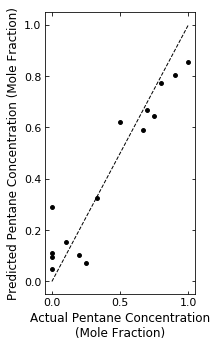

In [63]:
plot_regression(test_lbl, predicted, c=color["test"])
plt.tight_layout()
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C8 SVR.png', dpi=300)

In [64]:
predicted1 = predicted

##### Bagging classifier

In [65]:
#from sklearn.linear_model import Ridge
#from sklearn.model_selection import GridSearchCV
#
#def train_ridge(train_set, train_lbl, regions):
#    # prepare dictionary for regressions
#    regress_in = {}
#    
#    for region in set(regions): # changed this without checking on 5/8
#        # separate training set
#        X = [train_set[n] for n,reg in enumerate(regions) if reg == region]
#        Y = [train_lbl[n] for n,reg in enumerate(regions) if reg == region]
#        
#        # perform linear regression in region
#        regress_in[region] = GridSearchCV(Ridge(), cv=min(len(X),5), param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]})
#        regress_in[region].fit(X, Y)
#    
#    return regress_in
#
#
#def model_prediction(classifier, regression, test_set):
#    # prepare output of predictions
#    prediction = []
#
#    for deriv in test_set:
#        # reshape test data to conform with predictors
#        deriv = np.array(deriv).reshape(1,-1)
#
#        # determines the concentration level based on the random forest classifier
#        region = classifier.predict(deriv)[0] # high = break_clf.predict(deriv)
#        
#        # predict concentration
#        prediction.append(regression[region].predict(deriv))
#
#    return prediction

##### with segmented regression
requires PCA: segmented regression is performed on PC1

In [66]:
from piecewise.regressor import piecewise
from sklearn.decomposition import PCA

# split dataset into training and testing
train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs.values(), exp_concentrations.values(), test_size=1/2.5, random_state=0)

# perform PCA
pca = PCA()
train_pca = pca.fit_transform(train_derivs)
test_pca = pca.transform(test_derivs)

# run segmented regression algorithm
error_thresh = 0.07
model = piecewise(train_lbl,train_pca[:,0],error_thresh)

plot segmentation results

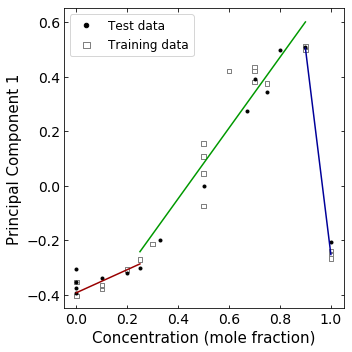

In [83]:
# plot segmented regression results
plt.figure(figsize = (5,5))
plt.plot(np.array(test_lbl),np.array(test_pca[:, 0]), '.', c=color["test"], label = "Test data")
plt.scatter(train_lbl, train_pca[:, 0],c='None', marker='s',s=20,edgecolors=color["train"],linewidths=1, label="Training data")
colors = segmentcolors #colors = [(.8, 0, 0), (0, .8, 0), (0, 0, .8)]
for n,seg in enumerate(model.segments):
    concs_new = [seg.start_t, seg.inclusive_end_t]
    y_hat = [seg.predict(conc) for conc in concs_new]
    plt.plot(concs_new, y_hat, c=np.array(colors[np.mod(n,len(colors))])*0.75)
    
plt.xlabel('Concentration (mole fraction)', fontsize = 15)
plt.ylabel('Principal Component 1', fontsize = 15)

ax = plt.gca()
ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = 14)

plt.legend(loc='upper left', fontsize = 12, markerscale = 1.5)
plt.tight_layout()
#plt.savefig('segmented_regression_explanation0.svg', bbox_layout='tight')
plt.tight_layout()
plt.xlim([-0.05, 1.05])
plt.ylim([-0.45, 0.65])
plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C8 segmReg.png', dpi=300)

perform bagging classification

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
import warnings

# split dataset into training and testing
train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs.values(), exp_concentrations.values(), test_size=1/2.5, random_state=0)

#------------------------------------------------------------#
# Bagging classifier with piecewise boundaries
#------------------------------------------------------------#
# get boundaries from piecewise model
for seg in model.segments:
    concs_new = [seg.start_t, seg.inclusive_end_t]
    y_hat = [seg.predict(conc) for conc in concs_new]

#defines boundaries of regression
break_y_da = []
for y in train_lbl:
    #for n, seg in enumerate(model.segments):
    findSegment = [y <= seg.inclusive_end_t for seg in model.segments]
    break_y_da.append(findSegment.index(True))

#creates classifier for the categories for low-medium and high concentration ranges.
break_clf = BaggingClassifier(n_estimators = 50, max_samples = 1.0, max_features = 10)
break_clf.fit(train_derivs, break_y_da)

#------------------------------------------------------------#
# Train regression and predict results
#------------------------------------------------------------#
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Train ridge regression for each region in break_y_da
    regressions = train_ridge(train_derivs, train_lbl, break_y_da, alpha = 0.003)

    # predict testing set concentrations
    predicted = model_prediction(break_clf, regressions, test_derivs)

    # calculate performance on training data as well
    matched = model_prediction(break_clf, regressions, train_derivs)

    print("Training accuracy: " + str(calculate_R2(train_lbl, matched)) + " (" + str(len(train_lbl)) + ")")
    print("Validation accuracy: " + str(calculate_R2(test_lbl, predicted)) + " (" + str(len(test_lbl)) + ")")

Training accuracy: 0.9558986510562854 (22)
Validation accuracy: 0.9435467035970145 (15)


Plotting

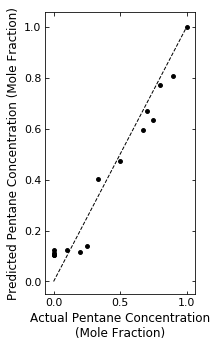

In [69]:
plot_regression(test_lbl, predicted)
plt.tight_layout()
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C8 segRegSVR.png', dpi=300)

Plot comparison

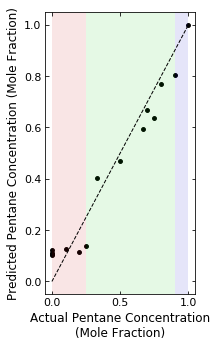

In [70]:
plt.figure(figsize = (3,5))
plt.xlabel('Actual Pentane Concentration\n(Mole Fraction)', fontsize = 12)
plt.ylabel('Predicted Pentane Concentration (Mole Fraction)', fontsize = 12)
ax = plt.gca()
ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = 11)
actual = test_lbl

# plot line representing 1:1 correspondence
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'--',c='k',linewidth=1)

# scatter non-segmented predictions
#plt.scatter(np.array(actual),np.array(predicted1),c=(0.5,0.5,0.5),s=15)
#plt.scatter(np.array(actual),np.array(predicted1),c='None', marker='o',s=20,edgecolors='r',linewidths=1)

# scatter predictions
plt.scatter(np.array(actual),np.array(predicted),c=color["test"],s=15)

# add model regions
colors = segmentcolors #colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
for n, segment in enumerate(model.segments):
    plt.axvspan(segment.start_t, segment.inclusive_end_t, facecolor=colors[np.mod(n,len(colors))], alpha=0.1)

# clean up plot and save
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.tight_layout()
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/C5-C8 segRegSVR+col.png', dpi=300)

## Physical properties of both mixtures
from 10.1016/0378-3812(95)02679-9

#### Pentane-Hexane

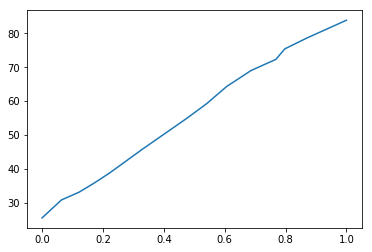

In [12]:
x1 = [0.0, 0.0638, 0.1218, 0.1700, 0.2213, 0.3291, 0.4750, 0.5401, 0.6064, 0.6864, 0.7683, 0.7977, 0.8729, 1]
P1 = [25.61, 30.90, 33.20, 35.80, 38.80, 45.80, 54.90, 59.20, 64.30, 69.00, 72.30, 75.40, 78.70, 83.82]
y1 = [0.0, 0.2011, 0.3054, 0.4141, 0.4678, 0.6166, 0.7480, 0.7808, 0.8409, 0.8825, 0.9232, 0.9355, 0.9511, 1]

plt.plot(x1,P1)

#### Pentane-Octane

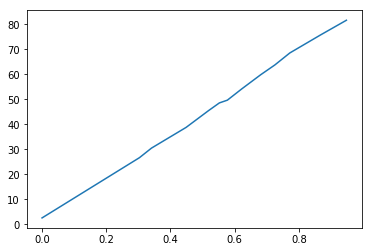

In [13]:
x2 = [0, 0.3034, 0.3409, 0.4488, 0.5185, 0.5524, 0.5773, 0.6220, 0.6813, 0.7252, 0.7718, 0.8673, 0.9481]
P2 = [2.55, 26.67, 30.50, 38.80, 45.50, 48.60, 49.70, 54.20, 59.90, 63.80, 68.60, 75.80, 81.70]
y2 = [0, 0.9298, 0.9415, 0.9623, 0.9714, 0.9778, 0.9793, 0.9801, 0.9821, 0.9873, 0.9917, 0.9957, 0.9999]

plt.plot(x2,P2,)

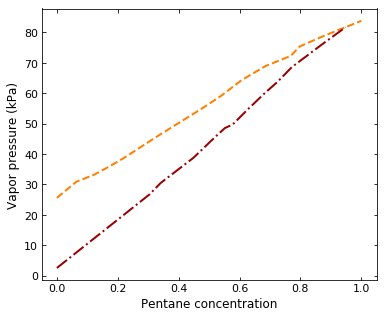

In [27]:
plt.figure(figsize = (6,5))
plt.xlabel('Pentane concentration', fontsize = 12)
plt.ylabel('Vapor pressure (kPa)', fontsize = 12)
ax = plt.gca()
ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = 11)

plt.plot(x1,P1,'--',c=(1,0.5,0),linewidth=2)
plt.plot(x2,P2,'-.',c=(0.6,0,0),linewidth=2)
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Vapor Pressure C5+X.png', dpi=300)

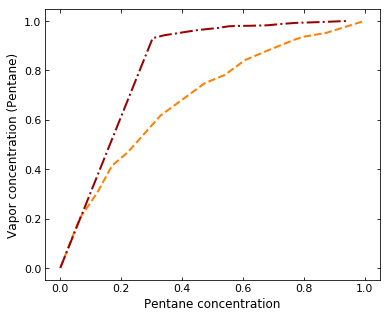

In [28]:
plt.figure(figsize = (6,5))
plt.xlabel('Pentane concentration', fontsize = 12)
plt.ylabel('Vapor concentration (Pentane)', fontsize = 12)
ax = plt.gca()
ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = 11)

plt.plot(x1,y1,'--',c=(1,0.5,0),linewidth=2)
plt.plot(x2,y2,'-.',c=(0.6,0,0),linewidth=2)
#plt.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Gas composition C5+X.png', dpi=300)